In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
block_size: int = 3

In [3]:
words: list[str] = open("names.txt", 'r').read().splitlines()
print(words[:10])
print(len(words))


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [4]:
chars: list[str] = sorted(list(set(''.join(words))))
stoi: dict[str, int] = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos: dict[int, str] = {i: char for char, i in stoi.items()}
char_cnt: int = len(stoi)
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def create_dataset(words: list[str], block_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    X: list[list[int]] = []
    Y: list[int] = []
    for word in words:
        context: list[int] = [0] * block_size
        for ix in word + '.':
            X.append(context)
            Y.append(stoi[ix])
            context = context[1:] + [stoi[ix]]
    X_t = torch.tensor(X)
    Y_t = torch.tensor(Y)
    print(X_t.shape, Y_t.shape)
    return torch.tensor(X), torch.tensor(Y)

# Build the dataset
X_t, Y_t = create_dataset(words[:5], block_size)


torch.Size([32, 3]) torch.Size([32])


In [6]:
X_t.shape, X_t.dtype, Y_t.shape, Y_t.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
embed_dim: int = 2
num_neurons: int = 100


In [8]:
C = torch.randn((char_cnt, embed_dim))

In [9]:
print(C[5])
# Metric C can also be seen as a linear layer with no bias.
F.one_hot(torch.tensor([5]), num_classes=len(stoi)).float() @ C


tensor([ 0.0315, -0.0078])


tensor([[ 0.0315, -0.0078]])

In [10]:
emb = C[X_t]
print(emb.shape)

torch.Size([32, 3, 2])


In [11]:
W1 = torch.randn((block_size * embed_dim, num_neurons))
b1 = torch.randn(num_neurons)


In [12]:
emb[:, 0, :]

tensor([[-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [ 0.0315, -0.0078],
        [ 0.6147,  0.8652],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [ 1.1672, -0.1058],
        [-0.3797,  0.5855],
        [ 1.8402,  0.2568],
        [ 1.3579,  0.5815],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [ 1.7676,  0.7109],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [ 1.8402,  0.2568],
        [ 0.2175,  0.5045],
        [ 1.7676,  0.7109],
        [-1.5424, -1.4075],
        [ 0.0315, -0.0078],
        [-0.3797,  0.5855],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [-0.5417,  0.8477],
        [ 0.2175,  0.5045],
        [ 1.1672, -0.1058],
        [-0.4887, -1.9960],
        [ 0.2225, -0.9698]])

In [13]:
print(torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape)
print(torch.cat(torch.unbind(emb, dim=1), dim=1).shape)
print(emb.view(-1, block_size * embed_dim).shape)

torch.Size([32, 6])
torch.Size([32, 6])
torch.Size([32, 6])


In [14]:
h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)


In [15]:
W2 = torch.randn((num_neurons, char_cnt))
b2 = torch.randn(char_cnt)

In [16]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [17]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [18]:
prob[0].sum()

tensor(1.0000)

In [19]:
prob[torch.arange(len(Y_t)), Y_t]

tensor([5.0094e-07, 4.0368e-07, 1.0045e-10, 5.5911e-12, 2.1997e-09, 7.6577e-10,
        1.5940e-14, 2.1973e-05, 6.5507e-07, 4.6835e-09, 1.4469e-10, 1.9156e-08,
        4.3384e-09, 1.2399e-04, 1.2353e-16, 6.0148e-10, 9.4090e-01, 1.5561e-02,
        6.3161e-17, 7.1892e-10, 1.1073e-06, 8.7613e-07, 1.0831e-06, 2.3962e-08,
        1.2653e-03, 8.7239e-06, 1.0484e-09, 5.5296e-04, 8.6529e-09, 2.6811e-05,
        2.9349e-10, 4.7647e-10])

In [20]:
loss = -prob[torch.arange(len(Y_t)), Y_t].log().mean()
loss

tensor(17.5645)

In [21]:
# Now group all the above code here.


In [22]:
X_t.shape, Y_t.shape


(torch.Size([32, 3]), torch.Size([32]))

In [23]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)
parameters = [C, W1, b1, W2, b2]


In [24]:
sum(p.nelement() for p in parameters)


3481

In [25]:
emb = C[X_t]
h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(len(Y_t)), Y_t].log().mean()
loss

tensor(17.7697)

In [26]:
# Fused kernel is faster than the above code:
# 1. It avoids the creation of intermediate variables.
# 2. Forward pass is more efficient.
# 3. Backward pass is more efficient.
# 4. Numerical stability is improved. `1000` in `(-3, -2, -1, 0, 10000).exp()` will be `nan`.
F.cross_entropy(logits, Y_t)


tensor(17.7697)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Now use the full dataset.
X_t, Y_t = create_dataset(words, block_size)
g = torch.Generator().manual_seed(2147483647)

torch.Size([228146, 3]) torch.Size([228146])


In [29]:
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 1000
lr = 0.1
loss = torch.tensor(1000.0)
for epoch in range(epochs):
    # Forward pass
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t)
    if (epoch % 10) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

# This is slow.
print(f"Final loss: {loss.item()}")

Epoch: 0, Loss: 19.505231857299805
Epoch: 10, Loss: 10.709590911865234
Epoch: 20, Loss: 8.329218864440918
Epoch: 30, Loss: 6.794988632202148
Epoch: 40, Loss: 5.803151607513428
Epoch: 50, Loss: 5.105473518371582
Epoch: 60, Loss: 4.587387561798096
Epoch: 70, Loss: 4.202611446380615
Epoch: 80, Loss: 3.928121328353882
Epoch: 90, Loss: 3.728707790374756
Epoch: 100, Loss: 3.575533628463745
Epoch: 110, Loss: 3.454464912414551
Epoch: 120, Loss: 3.3569204807281494
Epoch: 130, Loss: 3.2768971920013428
Epoch: 140, Loss: 3.2100894451141357
Epoch: 150, Loss: 3.153406858444214
Epoch: 160, Loss: 3.1044838428497314
Epoch: 170, Loss: 3.0616233348846436
Epoch: 180, Loss: 3.023682117462158
Epoch: 190, Loss: 2.9899871349334717
Epoch: 200, Loss: 2.9601333141326904
Epoch: 210, Loss: 2.9337902069091797
Epoch: 220, Loss: 2.9105937480926514
Epoch: 230, Loss: 2.8900628089904785
Epoch: 240, Loss: 2.8717215061187744
Epoch: 250, Loss: 2.855135440826416
Epoch: 260, Loss: 2.8400444984436035
Epoch: 270, Loss: 2.82624

In [30]:
mini_batch_size: int = 32
torch.randint(0, X_t.shape[0], (mini_batch_size,))


tensor([120563, 205263, 189624, 186019,  80790, 188612, 220059, 120536, 176814,
         45327, 182913, 112542,  41198, 161951,  43020, 102330,  32000,  29607,
        118224, 154647, 100455, 109254,  99060, 158357, 129823, 100252, 117982,
        130328, 140495, 218075,  55477,  21852])

In [31]:
def calculate_loss(X_t: torch.Tensor, Y_t: torch.Tensor) -> torch.Tensor:
    emb = C[X_t]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, Y_t)


In [32]:
# Use mini-batch to speed up the training.

C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 5000
lr = 0.1
loss = torch.tensor(1000.0)
mini_batch_size: int = 64

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_t.shape[0], (mini_batch_size,))
    X_t_mini = X_t[ix]
    Y_t_mini = Y_t[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 100) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

print(f"Final loss: {calculate_loss(X_t, Y_t).item()}")

Epoch: 0, Loss: 14.153608322143555
Epoch: 100, Loss: 3.38373064994812
Epoch: 200, Loss: 3.3496592044830322
Epoch: 300, Loss: 3.0131750106811523
Epoch: 400, Loss: 2.5643670558929443
Epoch: 500, Loss: 2.680514335632324
Epoch: 600, Loss: 2.5928945541381836
Epoch: 700, Loss: 2.5394842624664307
Epoch: 800, Loss: 2.5577001571655273
Epoch: 900, Loss: 2.86979341506958
Epoch: 1000, Loss: 2.7855210304260254
Epoch: 1100, Loss: 2.301349639892578
Epoch: 1200, Loss: 2.3991966247558594
Epoch: 1300, Loss: 2.598534345626831
Epoch: 1400, Loss: 2.7527966499328613
Epoch: 1500, Loss: 2.483114004135132
Epoch: 1600, Loss: 2.3076233863830566
Epoch: 1700, Loss: 2.6421995162963867
Epoch: 1800, Loss: 2.2344727516174316
Epoch: 1900, Loss: 2.601217031478882
Epoch: 2000, Loss: 2.7354815006256104
Epoch: 2100, Loss: 2.52819561958313
Epoch: 2200, Loss: 2.477076768875122
Epoch: 2300, Loss: 2.3097026348114014
Epoch: 2400, Loss: 2.4470133781433105
Epoch: 2500, Loss: 2.137772560119629
Epoch: 2600, Loss: 2.3119208812713623

In [33]:
# Find a good learning rate.
# Run the training for a few epochs find upper and lower bounds for the learning rate.

C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 1000
lr = 0.0001
loss = torch.tensor(1000.0)
mini_batch_size: int = 64

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_t.shape[0], (mini_batch_size,))
    X_t_mini = X_t[ix]
    Y_t_mini = Y_t[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

print(f"Final loss: {calculate_loss(X_t, Y_t).item()}")

Epoch: 0, Loss: 18.38080406188965
Epoch: 1, Loss: 17.38633155822754
Epoch: 2, Loss: 16.315900802612305
Epoch: 3, Loss: 15.307205200195312
Epoch: 4, Loss: 14.718621253967285
Epoch: 5, Loss: 16.051620483398438
Epoch: 6, Loss: 15.980152130126953
Epoch: 7, Loss: 15.637451171875
Epoch: 8, Loss: 16.634201049804688
Epoch: 9, Loss: 17.320039749145508
Epoch: 10, Loss: 17.414710998535156
Epoch: 11, Loss: 14.972213745117188
Epoch: 12, Loss: 17.503652572631836
Epoch: 13, Loss: 15.30620288848877
Epoch: 14, Loss: 15.491109848022461
Epoch: 15, Loss: 15.50281810760498
Epoch: 16, Loss: 15.929533004760742
Epoch: 17, Loss: 16.26514434814453
Epoch: 18, Loss: 15.290873527526855
Epoch: 19, Loss: 16.119945526123047
Epoch: 20, Loss: 14.143884658813477
Epoch: 21, Loss: 17.824371337890625
Epoch: 22, Loss: 16.777902603149414
Epoch: 23, Loss: 16.782245635986328
Epoch: 24, Loss: 15.849756240844727
Epoch: 25, Loss: 16.450551986694336
Epoch: 26, Loss: 16.75007438659668
Epoch: 27, Loss: 16.086727142333984
Epoch: 28, 

Epoch: 0, Loss: 21.65884780883789
Epoch: 1, Loss: 19.62009048461914
Epoch: 2, Loss: 21.204959869384766
Epoch: 3, Loss: 21.505403518676758
Epoch: 4, Loss: 20.491456985473633
Epoch: 5, Loss: 17.215011596679688
Epoch: 6, Loss: 18.583772659301758
Epoch: 7, Loss: 19.236474990844727
Epoch: 8, Loss: 18.867414474487305
Epoch: 9, Loss: 19.69000244140625
Epoch: 10, Loss: 17.324016571044922
Epoch: 11, Loss: 18.549636840820312
Epoch: 12, Loss: 15.523880004882812
Epoch: 13, Loss: 15.483967781066895
Epoch: 14, Loss: 17.257532119750977
Epoch: 15, Loss: 16.532398223876953
Epoch: 16, Loss: 15.14988899230957
Epoch: 17, Loss: 14.137533187866211
Epoch: 18, Loss: 13.42616081237793
Epoch: 19, Loss: 12.306650161743164
Epoch: 20, Loss: 14.695724487304688
Epoch: 21, Loss: 12.070423126220703
Epoch: 22, Loss: 11.018559455871582
Epoch: 23, Loss: 11.36786937713623
Epoch: 24, Loss: 12.122855186462402
Epoch: 25, Loss: 12.472930908203125
Epoch: 26, Loss: 10.861106872558594
Epoch: 27, Loss: 8.743474006652832
Epoch: 28

Text(0, 0.5, 'Loss')

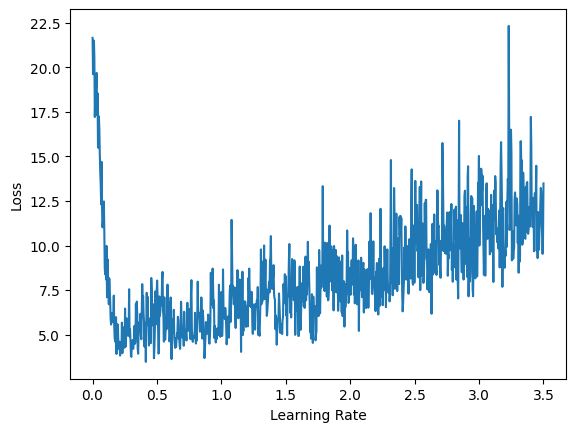

In [34]:
epochs = 1000
lrs = torch.linspace(0.0001, 3.5, epochs)

C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

loss = torch.tensor(1000.0)
mini_batch_size: int = 64

lr_tracker = []
loss_tracker = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_t.shape[0], (mini_batch_size,))
    X_t_mini = X_t[ix]
    Y_t_mini = Y_t[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = lrs[epoch]
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    # Track the learning rate and loss
    lr_tracker.append(lr.item())
    loss_tracker.append(loss.item())

plt.plot(lr_tracker, loss_tracker)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")


In [35]:
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

X_t = X_t.to(device)
Y_t = Y_t.to(device)
C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 60000
loss = torch.tensor(1000.0)
mini_batch_size: int = 64

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_t.shape[0], (mini_batch_size,))
    X_t_mini = X_t[ix]
    Y_t_mini = Y_t[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 30000 else  0.01 if epoch < 45000 else 0.001

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

print(f"Final loss: {calculate_loss(X_t, Y_t).item()}")

Epoch: 0, Loss: 16.34934425354004
Epoch: 1000, Loss: 2.7940874099731445
Epoch: 2000, Loss: 2.377312660217285
Epoch: 3000, Loss: 2.368765354156494
Epoch: 4000, Loss: 2.685065269470215
Epoch: 5000, Loss: 2.3207178115844727
Epoch: 6000, Loss: 2.396263360977173
Epoch: 7000, Loss: 2.514324188232422
Epoch: 8000, Loss: 2.320537567138672
Epoch: 9000, Loss: 2.370493173599243
Epoch: 10000, Loss: 2.5445196628570557
Epoch: 11000, Loss: 2.5043320655822754
Epoch: 12000, Loss: 2.367837905883789
Epoch: 13000, Loss: 2.2636637687683105
Epoch: 14000, Loss: 2.490281343460083
Epoch: 15000, Loss: 2.3011109828948975
Epoch: 16000, Loss: 2.652129888534546
Epoch: 17000, Loss: 2.395087242126465
Epoch: 18000, Loss: 2.3407673835754395
Epoch: 19000, Loss: 2.456930160522461
Epoch: 20000, Loss: 2.138148307800293
Epoch: 21000, Loss: 2.2620325088500977
Epoch: 22000, Loss: 2.4332196712493896
Epoch: 23000, Loss: 2.4930052757263184
Epoch: 24000, Loss: 2.1882870197296143
Epoch: 25000, Loss: 2.310624837875366
Epoch: 26000, 

In [36]:
# Generate train set, validation set and test set to solve the overfitting problem.

import random
random.seed(42)
random.shuffle(words)

train_set_ratio: float = 0.8
valid_set_ratio: float = 0.1
test_set_ratio: float = 0.1

n1: int = int(len(words) * train_set_ratio)
n2: int = int(len(words) * (train_set_ratio + valid_set_ratio))

X_train, Y_train = create_dataset(words[:n1], block_size)
X_val, Y_val = create_dataset(words[n1:n2], block_size)
X_test, Y_test = create_dataset(words[n2:], block_size)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# Increase the number of neurons to solve the underfitting problem.
num_neurons: int = 500
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f"parameters: {sum(p.nelement() for p in parameters)}")

epochs = 70000
loss = torch.tensor(1000.0)
mini_batch_size: int = 64

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 30000 else  0.01 if epoch < 45000 else 0.001

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

parameters: 17081
Epoch: 0, Loss: 50.758445739746094
Epoch: 1000, Loss: 3.606095314025879
Epoch: 2000, Loss: 3.0523128509521484
Epoch: 3000, Loss: 3.0084831714630127
Epoch: 4000, Loss: 3.3403542041778564
Epoch: 5000, Loss: 2.86464786529541
Epoch: 6000, Loss: 3.0591671466827393
Epoch: 7000, Loss: 2.3647260665893555
Epoch: 8000, Loss: 2.5702879428863525
Epoch: 9000, Loss: 2.807276725769043
Epoch: 10000, Loss: 2.7088024616241455
Epoch: 11000, Loss: 3.023799419403076
Epoch: 12000, Loss: 2.801056385040283
Epoch: 13000, Loss: 2.6311357021331787
Epoch: 14000, Loss: 2.689767599105835
Epoch: 15000, Loss: 2.515195608139038
Epoch: 16000, Loss: 2.7851264476776123
Epoch: 17000, Loss: 2.6605725288391113
Epoch: 18000, Loss: 2.7465333938598633
Epoch: 19000, Loss: 2.934049606323242
Epoch: 20000, Loss: 2.549147605895996
Epoch: 21000, Loss: 2.4800453186035156
Epoch: 22000, Loss: 2.668715715408325
Epoch: 23000, Loss: 2.204134225845337
Epoch: 24000, Loss: 3.1930549144744873
Epoch: 25000, Loss: 2.7330663204

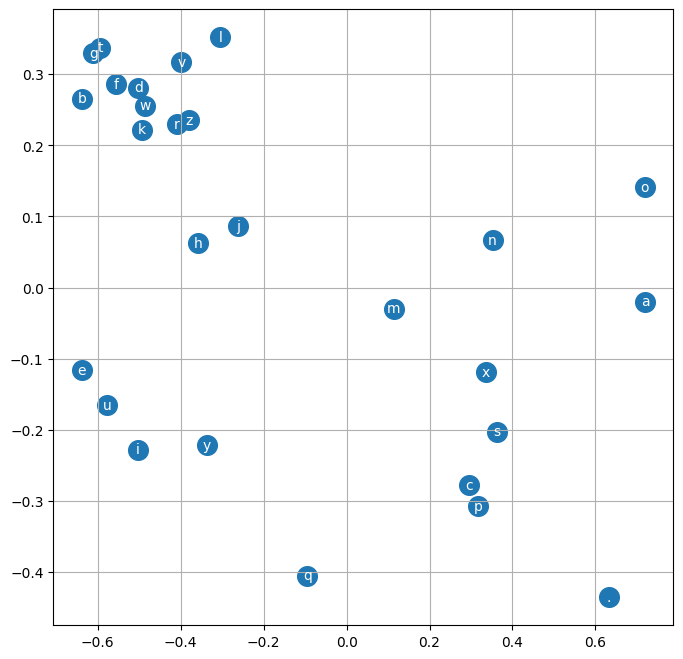

In [41]:
C = C.to('cpu')

plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid(True)


parameters: 36237
Epoch: 0, Loss: 36.42591094970703
Epoch: 1000, Loss: 5.554462432861328
Epoch: 2000, Loss: 3.9168083667755127
Epoch: 3000, Loss: 3.003911256790161
Epoch: 4000, Loss: 3.3169314861297607
Epoch: 5000, Loss: 3.238158702850342
Epoch: 6000, Loss: 4.040495872497559
Epoch: 7000, Loss: 2.71622896194458
Epoch: 8000, Loss: 2.8468880653381348
Epoch: 9000, Loss: 2.7568821907043457
Epoch: 10000, Loss: 2.97115159034729
Epoch: 11000, Loss: 2.912738561630249
Epoch: 12000, Loss: 2.3573110103607178
Epoch: 13000, Loss: 2.3219051361083984
Epoch: 14000, Loss: 2.9192028045654297
Epoch: 15000, Loss: 2.229011297225952
Epoch: 16000, Loss: 2.582505226135254
Epoch: 17000, Loss: 2.9248616695404053
Epoch: 18000, Loss: 3.2631654739379883
Epoch: 19000, Loss: 2.248654365539551
Epoch: 20000, Loss: 1.8772282600402832
Epoch: 21000, Loss: 2.3865561485290527
Epoch: 22000, Loss: 2.029405117034912
Epoch: 23000, Loss: 2.1012158393859863
Epoch: 24000, Loss: 2.3716657161712646
Epoch: 25000, Loss: 2.322397470474

Text(0, 0.5, 'Loss (log10)')

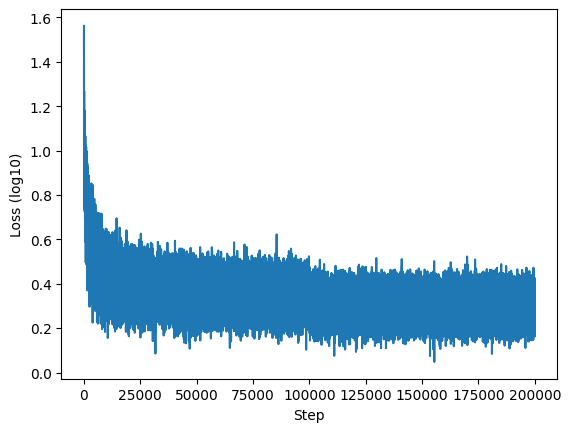

In [49]:
# Increase the number of the dimensions of the embedding to solve the underfitting problem.

num_neurons: int = 300
embed_dim: int = 30
C = torch.randn((char_cnt, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, char_cnt), generator=g)
b2 = torch.randn(char_cnt, generator=g)

C = C.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f"parameters: {sum(p.nelement() for p in parameters)}")

epochs = 200000
loss = torch.tensor(1000.0)
mini_batch_size: int = 32

lossi = []
stepi = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 100000 else  0.01 if epoch < 150000 else 0.001

    # Update the parameters
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss (log10)")


In [57]:
# Now sample from the trained model.

C = C.to('cpu')
W1 = W1.to('cpu')
b1 = b1.to('cpu')
W2 = W2.to('cpu')
b2 = b2.to('cpu')

g = torch.Generator().manual_seed(12123 + 10)
num_samples: int = 20

for _ in range(num_samples):
    out: list[str] = []
    context: list[int] = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix: int = int(
            torch.multinomial(probs, num_samples=1, generator=g).item()
        )
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


aarven.
carlowaian.
yam.
kallie.
greyar.
nyelly.
uriana.
samia.
zamedho.
rishivievero.
tiya.
ferneyleevalee.
jai.
zamarionato.
emani.
willey.
amaaq.
amarknena.
lorelle.
lauki.
